# Level 3 VQ-VAE Run Script

## Import a bunch of packages

In [1]:
import IPython

import torch
from torch.utils.data import DataLoader
import yaml
import matplotlib.pyplot as plt
import torchaudio

from models.multi_level_vqvae import MultiLvlVQVariationalAutoEncoder
from loaders.music_loader import MP3SliceDataset
from loaders.lvl3_loader import Lvl3InputDataset
from utils.other import load_cfg_dict

## Load configuration files and add weights paths

In [2]:
config_path_lvl1 = "config/lvl1_config.yaml"
weights_path_lvl1 = "model_weights/lvl1_vqvae.ckpt"
#weights_path = "model_best.ckpt"
cfg_1 = load_cfg_dict(config_path_lvl1)

config_path_lvl2 = "config/lvl2_config.yaml"
weights_path_lvl2 = "model_weights/lvl2_vqvae.ckpt"
#weights_path = "model_best.ckpt"
cfg_2 = load_cfg_dict(config_path_lvl2)

config_path_lvl3 = "config/lvl3_config.yaml"
weights_path_lvl3 = "model_weights/lvl3_vqvae.ckpt"
#weights_path = "model_best.ckpt"
cfg_3 = load_cfg_dict(config_path_lvl3)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Load the models

In [3]:
model_lvl1 = MultiLvlVQVariationalAutoEncoder(**cfg_1).to(device)
model_lvl1 = model_lvl1.load_from_checkpoint(weights_path_lvl1, **cfg_1, strict=False).to(device)
model_lvl1.eval()

model_lvl2 = MultiLvlVQVariationalAutoEncoder(**cfg_2).to(device)
model_lvl2 = model_lvl1.load_from_checkpoint(weights_path_lvl2, **cfg_2, strict=False).to(device)
model_lvl2.eval()

model_lvl3 = MultiLvlVQVariationalAutoEncoder(**cfg_3).to(device)
model_lvl3 = model_lvl1.load_from_checkpoint(weights_path_lvl3, **cfg_3, strict=False).to(device)
model_lvl3.eval()

/home/vovatch/anaconda3/envs/VovaTch/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(
/home/vovatch/anaconda3/envs/VovaTch/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (64) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(
/home/vovatch/anaconda3/envs/VovaTch/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:49: PossibleUserWarning: The loaded checkpoint was produced with Lightning v1.9.3, which is newer than your current Lightning version: v1.9.0
  rank_zero_warn(
/home/vovatch/anaconda3/envs/VovaTch/lib/python3.9/site-packages/torchaudio/functional/functional.py:507: UserWarning: At least one mel filterbank has 

MultiLvlVQVariationalAutoEncoder(
  (mel_spec): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (mel_spec_sub_1): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (mel_spec_sub_2): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
  (encoder): Encoder1D(
    (init_conv): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv_list): ModuleList(
      (0): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (1): GELU()
          (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,))
          (4): GELU()
        )
      )
      (1): ConvBlock1D(
        (architecture): Sequential(
          (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
          (1): GELU()
          (2): 

### HTML wrapper to display sound clips:

In [4]:
# this is a wrapper that take a filename and publish an html <audio> tag to listen to it

def wavPlayer(filepath):
    """ will display html 5 player for compatible browser

    Parameters :
    ------------
    filepath : relative filepath with respect to the notebook directory ( where the .ipynb are not cwd)
               of the file to play

    The browser need to know how to play wav through html5.

    there is no autoplay to prevent file playing when the browser opens
    """
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source src="files/%s" type="audio/mp3" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """%(filepath)
    display(HTML(src))

## Load a dataset sample and display it.

### Load the slice

Loading file data/music_samples/002-datatensor.pt...
Music file data/music_samples/002-datatensor.pt is loaded.
Loading file data/music_samples/002-metadata.pkl...
Music file data/music_samples/002-metadata.pkl is loaded.
Current track is data/music_samples/11 Infected Mushroom - The Legend Of The Black Shawarma.mp3


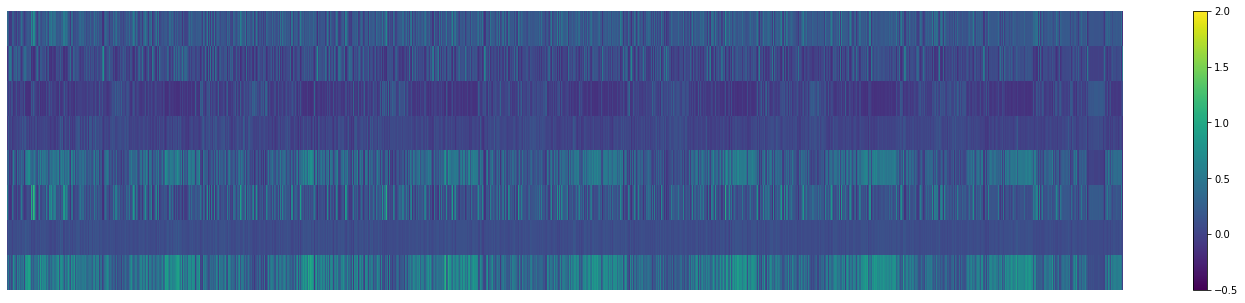

In [5]:
dataset = Lvl3InputDataset(preload=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)
for sample in dataloader:
    lvl3_sample = sample['music slice'].squeeze(0)
    print(f"Current track is {sample['track name'][0]}")
    break
plt.figure(figsize=(25, 5))
plt.matshow(lvl3_sample.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-0.5, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Run the level 3 network and show results

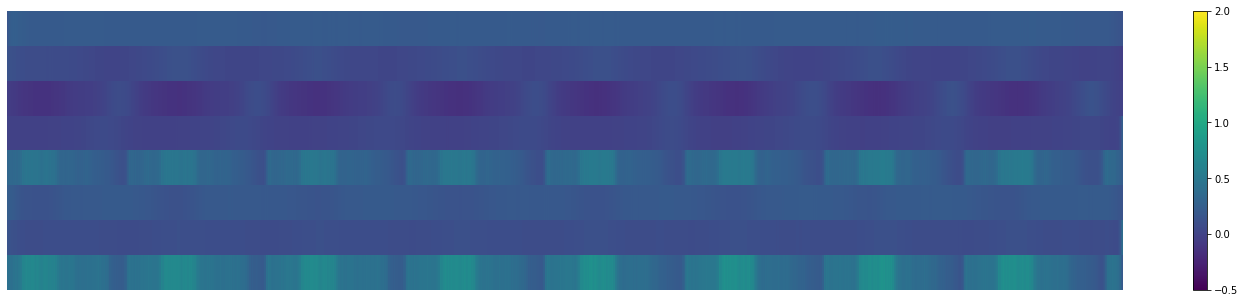

torch.Size([8, 4096]) torch.Size([8, 4096])


In [6]:
lvl3_output = model_lvl3(lvl3_sample.clone().unsqueeze(0).to(device), extract_losses=False)
with torch.no_grad():
    lvl2_pred = lvl3_output['output'][0]
plt.figure(figsize=(25, 5))
plt.matshow(lvl2_pred.cpu().detach().numpy(), fignum=1, aspect='auto', vmin=-0.5, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()
print(lvl2_pred.size(), lvl3_sample.size())

## Show the subtraction between the ground truth and the reconstruction

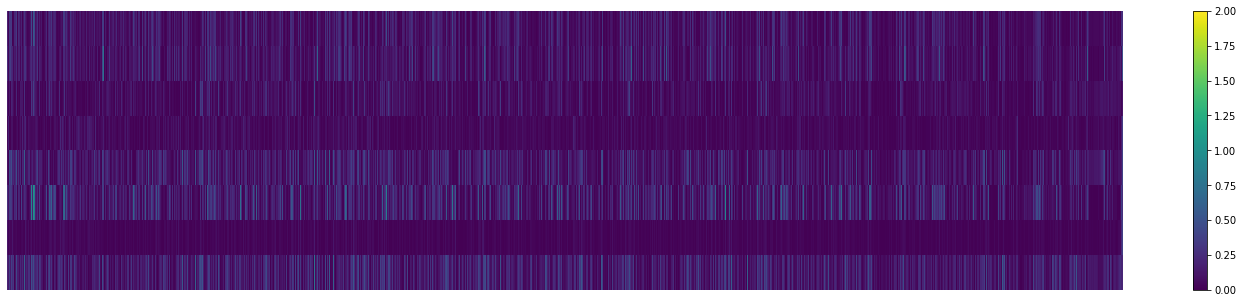

In [7]:
plt.figure(figsize=(25, 5))
plt.matshow(torch.abs(lvl3_sample.cpu() - lvl2_pred.cpu()).detach().numpy(), fignum=1, aspect='auto', vmin=0, vmax=2.0)
plt.colorbar()
plt.axis('off')
plt.show()

## Pass the level 2 outputs through the level 1 decoder and make MUSIC!

### Sanity Check, reconstruction of the lvl1 data

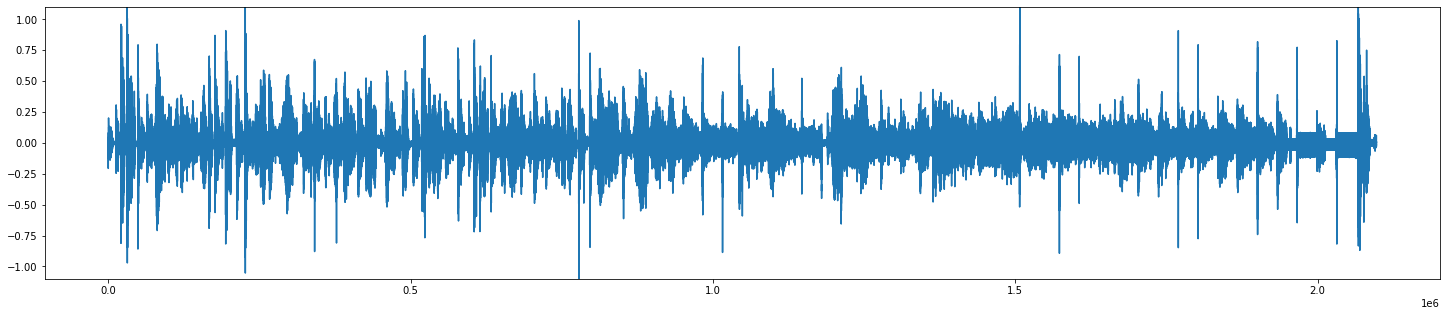

In [14]:
batch_size = 8

with torch.no_grad():
    # z_q_out = vq_input
    z_q_out_lvl2 = model_lvl2.vq_module(lvl3_sample.unsqueeze(0).to(device))['v_q']
    output_lvl2 = model_lvl2.decoder(z_q_out_lvl2)
    output_lvl2 = output_lvl2.view((output_lvl2.shape[0] * batch_size, cfg_1['latent_depth'], -1))
    output_lvl1 = torch.zeros([1, cfg_1['input_channels'], 0]).to(device=device)
    
    for batch in output_lvl2:
        batch = batch.unsqueeze(0)
        z_q_out = model_lvl1.vq_module(batch.to(device))['v_q']
        output_part = model_lvl1.decoder(z_q_out)
        output_lvl1 = torch.cat((output_lvl1, output_part), dim=2)
    
music_sample_rec = output_lvl1.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")

### CREATE MUSIC!!!

In [ ]:
with torch.no_grad():
    # z_q_out = vq_input
    z_q_out_lvl2 = model_lvl2.vq_module(lvl2_pred.unsqueeze(0).to(device))['v_q']
    output_lvl2 = model_lvl2.decoder(z_q_out_lvl2)
    output_lvl2 = output_lvl2.view((output_lvl2.shape[0] * batch_size, cfg_1['latent_depth'], -1))
    output_lvl1 = torch.zeros([1, cfg_1['input_channels'], 0]).to(device=device)
    
    for batch in output_lvl2:
        batch = batch.unsqueeze(0)
        z_q_out = model_lvl1.vq_module(batch.to(device))['v_q']
        output_part = model_lvl1.decoder(z_q_out)
        output_lvl1 = torch.cat((output_lvl1, output_part), dim=2)
    
music_sample_rec = output_lvl1.view((1, -1))
plt.figure(figsize=(25, 5))
plt.plot(music_sample_rec[0, ...].cpu().detach().numpy())
plt.ylim((-1.1, 1.1))
plt.show()
torchaudio.save('sample_out.mp3', music_sample_rec.cpu().detach(), 44100, format='mp3')
IPython.display.Audio(filename="sample_out.mp3")